# Text Pre-Processing 

In [14]:
# Utilities
from joblib import Parallel, delayed
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
from multiprocessing import Pool, cpu_count
import warnings 
warnings.filterwarnings("ignore")
import os
import tqdm
from tqdm import tqdm
tqdm.pandas(desc="progress bar")

# Data Manipulation 
import pandas as pd
import numpy as np

# Import time packages 
import time
import datetime

# Visualization Tools
import matplotlib.pyplot as plt

# Packages needed for text pre-processing:
import nltk 
import spacy 
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokens import Doc
from spacy.language import Language
import re
import contractions
import emoji
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Sentiment Packages
from textblob import TextBlob

# sklearn packages
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
# !python -m spacy download en_core_web_md
# !pip install wordcloud, emoji
# !pip install ipywidgets
# !pip install pandarallel
# !pip install textblob
#!python -m spacy download en_core_web_md 

In [4]:
from utils import search_folder
current_dir = os.getcwd()
thesis_folder_path = current_dir.replace("/laptop code/thesis_code", "")
twitter_data_path = search_folder(thesis_folder_path,"twitter_data")
eikon_data_path = search_folder(thesis_folder_path,"eikon_news")

In [5]:
tweets_master_df = pd.read_csv(twitter_data_path+"/master_Ctweets_df.csv")

In [6]:
# Converting datetime column to correct format 
tweets_master_df["datetime"] = pd.to_datetime(tweets_master_df["datetime"], errors= "coerce")
tweets_master_df = tweets_master_df.dropna(subset= ["datetime"])

# Dropping any possible dupliates. Hence we sort all rows by the below columns 
tweets_master_df = tweets_master_df.sort_values(['datetime', 'username', 'text', 'retweet_count', "likeCount"], ascending=[True, True, True, False, False])

# Dropping rows where datetime, username, text are all equally the same. 
tweets_master_df = tweets_master_df.drop_duplicates(subset=['datetime', 'username', 'text'], keep='first')
tweets_master_df = tweets_master_df.reset_index(drop = True)

# Making sure that we either get the text from the text column or from the rendered_content
tweets_master_df.loc[tweets_master_df['text'].isna(), 'text'] = tweets_master_df['rendered_content']
tweets_master_df["rendered_content"] = tweets_master_df['text']

In [7]:
tweets_master_df.head()

,datetime,username,text,rendered_content,likeCount,reply_count,retweet_count,retweeted,view_count,company
0,2017-01-01 00:04:53+00:00,MacHashNews,Review: Bragi's Headphone offers a solid alter...,Review: Bragi's Headphone offers a solid alter...,0.0,0.0,2.0,NaN,NaN,APPL
1,2017-01-01 00:05:05+00:00,marketexclusive,Analyst Activity – Robert W. Baird Reiterates ...,Analyst Activity – Robert W. Baird Reiterates ...,0.0,0.0,7.0,NaN,NaN,TSLA
2,2017-01-01 00:14:25+00:00,helpYOUgetGAINS,Roasted Persian Chicken and Cauliflower | Mark...,Roasted Persian Chicken and Cauliflower | Mark...,0.0,0.0,0.0,NaN,NaN,APPL
3,2017-01-01 00:38:06+00:00,jhamby,Apple also integrated DTrace into macOS and wr...,Apple also integrated DTrace into macOS and wr...,0.0,0.0,0.0,NaN,NaN,APPL
4,2017-01-01 00:54:59+00:00,HuffPost,Google combats Holocaust-denying search result...,Google combats Holocaust-denying search result...,151.0,10.0,63.0,NaN,NaN,GOOGL


In [8]:
tweets_master_df.company.value_counts()

TSLA     1250193
APPL      674679
GOOGL     184195
MRNA       48780
Name: company, dtype: int64

---
#### Visualisation of all tweets before text preprocessing

In [ ]:
tweets_master_df.company.value_counts()

TSLA     1250193
APPL      674679
GOOGL     184195
MRNA       48780
Name: company, dtype: int64

In [12]:
from wordcloud import WordCloud

100%|██████████| 2157988/2157988 [00:00<00:00, 2667521.44it/s]


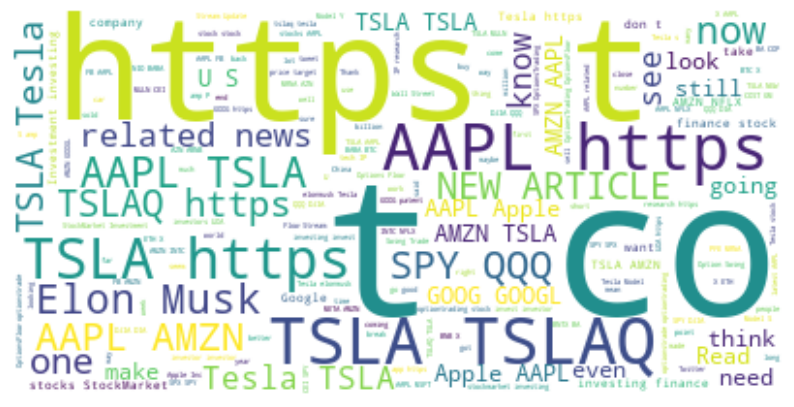

In [13]:
train_text= " ".join(i for i in tqdm(tweets_master_df["text"]))
stopwords = set(STOP_WORDS)
wordcloud = WordCloud(background_color="white").generate(train_text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [10]:
tweets_master_df_test = tweets_master_df.iloc[:1000]

---
### Text cleaner

In [11]:
contraction_mappings = {
    "(goog)" : "",
    "(aapl)" : "",
    "(tsla)" : "",
    "(mrna)" : "",
    "r": "are",
    "w/": "with",
    "u": "you",
    "ur": "your",
    "n": "and",
    "b/c": "because",
    "w/o": "without",
    "w/" : "with", 
    "tsla": "tesla", 
    "aapl" : "apple",
    "mrna" : "moderna", 
    "goog" : "google",
    "read more" : ""
  }
  
for k, v in contraction_mappings.items():
    contractions.add(k, v)

In [12]:
text = "How r u, I'm fine and u, he is w/ him, i can't deal with you, Still can't"
contractions.fix(str(text))

'How are you, I am fine and you, he is with him, i cannot deal with you, Still cannot'

In [13]:
text = "I just ate 🍕 and i feel 😊 now, but now i am 😠"
emoji.demojize(text).replace(":"," ").replace("_"," ")

'I just ate  pizza  and i feel  smiling face with smiling eyes  now, but now i am  angry face '

In [14]:
nlp = spacy.load("en_core_web_md")

In [15]:
def clean_text(text: str):

    #  1. Lowering capital letters 
    text = text.lower()
    
    # 2. Replacing dollar sign with empty space
    try: 
        text = " ".join((token.text if (token.text.startswith('$') and token.nbor(1).like_num) 
                         else token.text.replace('$', '')) for token in nlp(text))
    except:
        None 

    # 3. Undoing contractions
    text = contractions.fix(text)
    
    # 4. Converting emojis into text
    text = emoji.demojize(text).replace(":"," ").replace("_"," ")
    
    # 5. Removing any special characters
    text = " ".join(token.text for token in nlp(text) if
                                                not token.like_email
                                                and not token.is_bracket
                                                and not token.is_punct
                                                and not token.like_url)
    
    # 6. Remove character that start with https 
    text = re.sub(r'(http\S+)|(\b(\w+)\s+\3\b)', '', text)
  
    # 7. Remove any spaces or words that are not in the vocabulary
    text = " ".join(token.text for token in nlp(text) if not token.is_space
                                                      and not token.is_oov
                                                      or token.like_num
                                                      )

    return text

In [16]:
#cleaned_tweets_df = tweets_master_df.iloc[:30000]   
cleaned_tweets_df = tweets_master_df.copy()

In [18]:
tweets_master_df_test["cleaned_text"] = tweets_master_df_test["text"].parallel_apply(lambda x: clean_text(x))

In [22]:
cleaned_tweets_df.head()

,datetime,username,text,rendered_content,likeCount,reply_count,retweet_count,retweeted,view_count,company,cleaned_text
0,2017-01-01 00:04:53+00:00,MacHashNews,Review: Bragi's Headphone offers a solid alter...,Review: Bragi's Headphone offers a solid alter...,0.0,0.0,2.0,NaN,NaN,apple,review 's headphone offers a solid alternative...
1,2017-01-01 00:05:05+00:00,marketexclusive,Analyst Activity – Robert W. Baird Reiterates ...,Analyst Activity – Robert W. Baird Reiterates ...,0.0,0.0,7.0,NaN,NaN,tesla,analyst activity robert w. baird reiterates to...
2,2017-01-01 00:14:25+00:00,helpYOUgetGAINS,Roasted Persian Chicken and Cauliflower | Mark...,Roasted Persian Chicken and Cauliflower | Mark...,0.0,0.0,0.0,NaN,NaN,apple,roasted persian chicken and cauliflower | mark...
3,2017-01-01 00:38:06+00:00,jhamby,Apple also integrated DTrace into macOS and wr...,Apple also integrated DTrace into macOS and wr...,0.0,0.0,0.0,NaN,NaN,apple,apple also integrated into macos and wrote som...
4,2017-01-01 00:54:59+00:00,HuffPost,Google combats Holocaust-denying search result...,Google combats Holocaust-denying search result...,151.0,10.0,63.0,NaN,NaN,google,google combats holocaust denying search result...


In [23]:
cleaned_tweets_df.to_csv(twitter_data_path +"/cleaned_tweets_df.csv", index = False)

In [15]:
cleaned_tweets_df["company"] = cleaned_tweets_df["company"].replace(to_replace='.*MRNA.*', value='moderna', regex=True) \
    .replace(to_replace='.*GOOGL.*', value='google', regex=True) \
    .replace(to_replace='.*TSLA.*', value='tesla', regex=True) \
    .replace(to_replace='.*APPL.*', value='apple', regex=True)

100%|██████████| 2157988/2157988 [00:00<00:00, 5045119.79it/s]


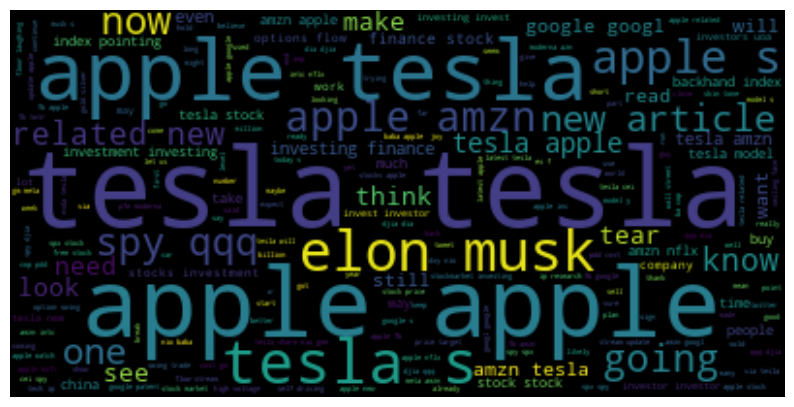

In [ ]:
#visualisation of positive sentiments
train_text= " ".join(i for i in tqdm(cleaned_tweets_df["cleaned_text"]))
wordcloud = WordCloud(background_color="black").generate(train_text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [16]:
def display_text_comparison(df, limit: int, jump: int):
    for number in range(0,limit, jump):
        print(df[["text"]].values[number])
        print(df[["cleaned_text"]].values[number])

In [17]:
display_text_comparison(cleaned_tweets_df,7000, 100)

["Review: Bragi's Headphone offers a solid alternative to Apple AirPods https://t.co/VkAswgXy4m #AppleInsider $AAPL https://t.co/0vq9qGKs2R"]
["review 's headphone offers a solid alternative to apple airpods m apple"]
['Pretty solid wrap up of the current stock price situation on $TSLA on Forbes. https://t.co/yt3Hlw3HCX']
['pretty solid wrap up of the current stock price situation on tesla on forbes']
['Guyasuta Investment Advisors Inc. Has $12,125,000 Position in Alphabet Inc. $GOOG https://t.co/GUNAQE9DBY']
['investment advisors inc has $ 12,125,000 position in alphabet inc google']
['@markbspiegel @TeslaMotors true dat. Happy New Years $TSLA. The year when ugly goes to disaster...or as Ben kallo puts it PT hiked 300+&gt;~400']
['true dat happy new years tesla the year when ugly goes to disaster or as ben puts it pt hiked']
["What happens if capitalism becomes mini monopolies wouldn't that affect quality of life for the majority of the population? $aapl $spy $qqq https://t.co/gXwYNT1

---
### Eikon Reuters News Sources

In [25]:
eikon_news_df = pd.read_csv(eikon_data_path + "/master_eikon_df.csv",  date_parser = "datetime")
eikon_news_df = eikon_news_df.sort_values(by = "datetime", ascending = True).reset_index(drop = True)
eikon_news_df.head()

,datetime,source,stock,text,company
0,2017-01-01 12:44:28,ZOLCOM,AAPL.OQ,Apple Inc. (AAPL) Sees Large Drop in Short Int...,APPL
1,2017-01-01 16:34:58,ZOLCOM,AAPL.OQ,"JLB & Associates Inc. Has $10,751,000 Position...",APPL
2,2017-01-02 09:24:17,RTRS,.GDAXI .IBEX,German and French share indexes start 2017 on ...,APPL
3,2017-01-02 09:52:42,RTRS,AAPL.O DLGS.DE,BUZZ-Dialog Semi: Falls on report Apple plans ...,APPL
4,2017-01-02 22:54:59,AMEBAN,TSLA.OQ,"Tesla Motors, Inc. (TSLA) Downgraded by Vetr Inc.",TSLA


In [26]:
eikon_news_df["company"] = eikon_news_df["company"].replace(to_replace='.*MRNA.*', value='moderna', regex=True) \
    .replace(to_replace='.*GOOGL.*', value='google', regex=True) \
    .replace(to_replace='.*TSLA.*', value='tesla', regex=True) \
    .replace(to_replace='.*APPL.*', value='apple', regex=True)
cleaned_eikon_news_df = eikon_news_df.copy()

In [27]:
cleaned_eikon_news_df["cleaned_text"] = cleaned_eikon_news_df["text"].parallel_apply(lambda x: clean_text(x))

In [ ]:
cleaned_eikon_news_df.to_csv(eikon_data_path+ "/cleaned_eikon_news_df.csv", index = False)

In [28]:
cleaned_eikon_news_df.head()

,datetime,source,stock,text,company,cleaned_text
0,2017-01-01 12:44:28,ZOLCOM,AAPL.OQ,Apple Inc. (AAPL) Sees Large Drop in Short Int...,apple,apple inc apple sees large drop in short interest
1,2017-01-01 16:34:58,ZOLCOM,AAPL.OQ,"JLB & Associates Inc. Has $10,751,000 Position...",apple,"associates inc has $ 10,751,000 position in ap..."
2,2017-01-02 09:24:17,RTRS,.GDAXI .IBEX,German and French share indexes start 2017 on ...,apple,german and french share indexes start 2017 on ...
3,2017-01-02 09:52:42,RTRS,AAPL.O DLGS.DE,BUZZ-Dialog Semi: Falls on report Apple plans ...,apple,buzz dialog semi falls on report apple plans i...
4,2017-01-02 22:54:59,AMEBAN,TSLA.OQ,"Tesla Motors, Inc. (TSLA) Downgraded by Vetr Inc.",tesla,tesla motors inc tesla downgraded by inc


In [29]:
cleaned_eikon_news_df.company.value_counts()

apple      19142
tesla      18337
moderna     6944
Name: company, dtype: int64

In [30]:
#eikon_Cnews_df.to_csv(eikon_data_path+ "/cleaned_eikon_news.csv", index = False)

In [31]:
display_text_comparison(cleaned_eikon_news_df,20000, 1000)

['Apple Inc. (AAPL) Sees Large Drop in Short Interest']
['apple inc apple sees large drop in short interest']
['Credit Suisse Group AG Analysts Give Apple Inc. (AAPL) a $170.00 Price Target']
['credit suisse group ag analysts give apple inc apple a $ 170.00 price target']
['Japanese stocks attract biggest inflows in seven week, BAML says']
['japanese stocks attract biggest inflows in seven week says']
['Balancing act: Chip giant Qualcomm caught between Washington and Beijing']
['balancing act chip giant caught between washington and beijing']
['Novare Capital Management LLC Has $12.27 Million Holdings in Apple (AAPL)']
['capital management llc has $ 12.27 million holdings in']
['Trump slams social media firms for "silencing millions"']
['trump slams social media firms for silencing millions']
["Don't be distracted by Tesla's surprise profit — all that matters is how much money the company is bringing in (TSLA)"]
["do be distracted by tesla 's surprise profit all that matters is how muc